In [67]:
# Block 1: Data generation
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
l = 1000 # 1000 time steps
t = np.linspace(0, 100, l) # a time interval of 100 seconds
a = np.zeros(1000) # initialize accelaration
v = np.zeros(1000) # initialize velocity
s = np.zeros(1000) # initialize position
variance_Zs = 0 # variance of system error with respect to position
variance_Zv = 0  # variance of system error with respect to velocity
variance_Za = 0 # variance of system error with respect to acceleration
variance_Ms = 0.1 # /sigma_Ms^2 = 20 # variance of measurement error with respect to position
variance_Mv = 0.01 # /sigma_Ms^2 = 2 # variance of measurement error with respect to velocity
variance_Ma = 0.0001 # /sigma_Ma^2 =0.2 # variance of measurement error with respect to acceleration
noise_Zs = np.random.normal(0,variance_Zs,1000)
noise_Zv = np.random.normal(0,variance_Zv,1000) 
noise_Za = np.random.normal(0,variance_Za,1000) 
noise_Ms = np.random.normal(0,variance_Ms,1000)  
noise_Mv = np.random.normal(0,variance_Mv,1000)
noise_Ma = np.random.normal(0,variance_Ma,1000)
Ts = 100/l
# x = Ad * x + Bd * u + Gd * z
# y = C * x + Md * w
Ad = np.matrix([[1,Ts,0.5*(Ts*Ts)],
                  [0,1,Ts],
                  [0,0,0]]) ##  0,0,0 for the simulation of real physical system
Bd = np.array ([0.5*(Ts*Ts),Ts,1]).reshape(-1,1)
u = np.zeros((1,1000))
u[:,200:225] = -10 # step function
G = np.matrix ([[1,0,0],[0,1,0],[0,0,1]])
Gd = G
Md = G
C = np.matrix ([[1,0,0],[0,1,0],[0,0,1]])
#D = np.array ([0,0,1]).reshape(-1,1) #we do not include control input in the measurement

z = np.vstack((noise_Zs,noise_Zv,noise_Za))
w = np.vstack((noise_Ms,noise_Mv,noise_Ma))

StateMatrix = np.zeros((3,1000))
MeasurementMatrix = np.zeros((3,1000))
v[0] = 50#initial velocity
x = np.array ([[s[0]],[v[0]],[a[0]]])
y = np.array ([0,0,0])
z_0 = z[:,0].reshape (3,1)
w_0 = w[:,0].reshape (3,1)

StateMatrix[:,0] = np.squeeze(x)
MeasurementMatrix[:,0] = np.squeeze(y)
for k in range(0, len(t)):
      z_k = z[:,k].reshape (3,1)
      w_k = w[:,k].reshape (3,1)
      u_k = u[:,k].reshape (1,1)
      x = Ad * x + Bd * u_k + Gd * z_k
      y = C * x + Md * w_k
      StateMatrix[:,k] = np.squeeze(x)
      MeasurementMatrix[:,k] = np.squeeze(y)

In [72]:
# Block 2: Kalman filter implementation
StateEstimate = np.zeros((3, len(t)))

#The Q and R basically describes which values do we emphasize more, the measurement or the prediction
# Q = np.diag([variance_Zs, variance_Zv, variance_Za]) 
# R = np.diag([variance_Ms, variance_Mv, variance_Ma])
Q = np.diag([0.001, 0.001, 0.001]) 
R = np.diag([50, 10, 1])

# Initial state estimate
#x_hat = np.zeros((3, 1))#here I give a more precise inital estimated value, hoping to imprive the performance
x_hat = np.array([0, 50, 0]).reshape(-1, 1)

StateEstimate[:,0] = np.squeeze(x_hat)

# Initial error covariance matrix
P_ini = np.diag([1000, 1000, 1000])
P = P_ini

# Prediction step

# x_pred = Ad_f * x + Gd_f * z
# y = C_f * x + Md_f * w
    #should we include the term Bd*u in  the prediction step of Kalman Filter? 
        #I would say we shouldn't, because we do not know about the control input of the other vehicles.

Ad_f = np.matrix([[1,Ts,0.5*(Ts*Ts)], # The Ad_f is the stat transition matrix that we use as prediction in the filter
                    [0,1,Ts],
                   [0,0,1]]) ## Ad_f should be 0,0,1 (assume cosntant acceleration) because we do not know the real dynamics of the object vehicle

Gd_f = Gd # Gd_f is the Gd we use in the filter frocess, it should be the same as in the datageneration process
C_f = C
Md_f = Md 


for k in range(0, len(t)):

    x_hat_pred = Ad_f.dot(x_hat) #x_hat_pred is the predicted state based on the last state of x_hat (Markov Chain)
    
    P_pred = Ad_f.dot(P).dot(Ad.T) + Gd_f.dot(Q).dot(Gd_f.T)

    # Update step

    y = MeasurementMatrix[:,k].reshape(-1,1)
    S = C_f.dot(P_pred).dot(C_f.T) + Md_f.dot(R).dot(Md_f.T)
    #K = P_minus.dot(C.T).dot(np.linalg.inv(S))
    K = P_pred.dot(C_f.T).dot(np.linalg.pinv(S))
    x_hat = x_hat_pred + K.dot(y - C_f.dot(x_hat_pred))
    P = (np.eye(3) - K.dot(C_f)).dot(P_pred)
    
    # Save the estimated state
    StateEstimate[:,k] = np.squeeze(x_hat)

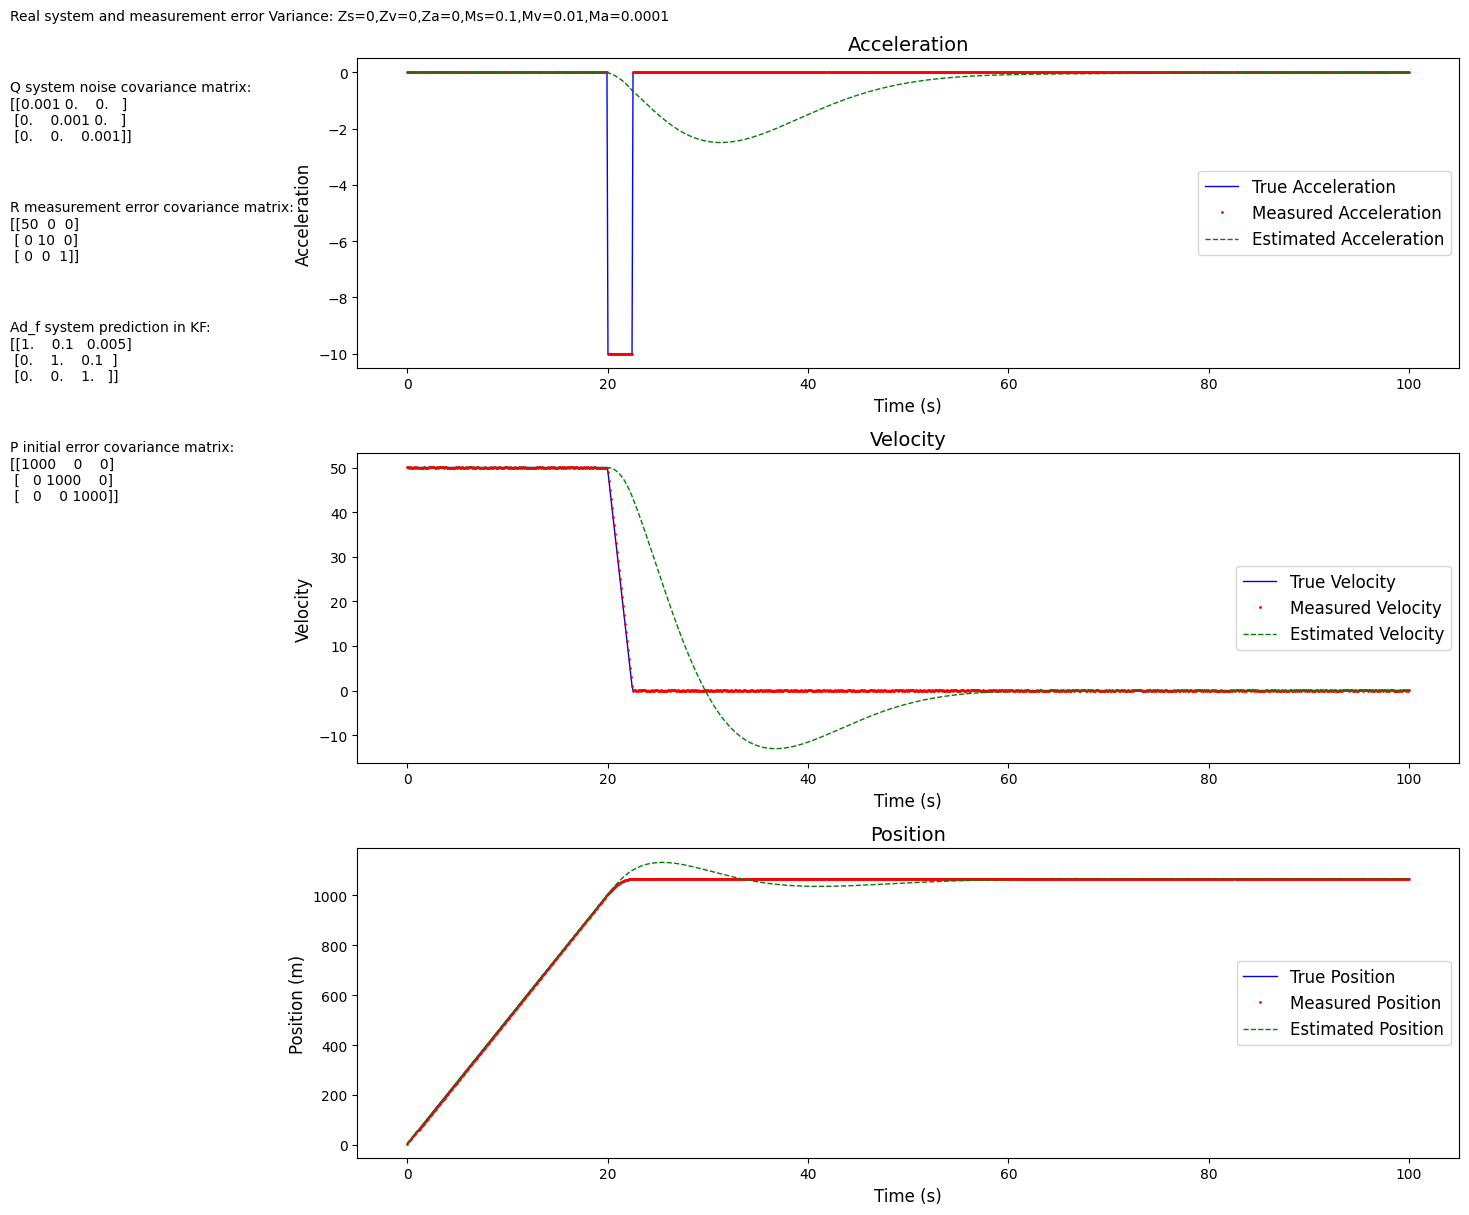

In [73]:
import matplotlib.pyplot as plt

# Plotting the true, measured, and estimated position
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

fig.text(-0.22,1, f'Real system and measurement error Variance: Zs={variance_Zs},Zv={variance_Zv},Za={variance_Za},Ms={variance_Ms},Mv={variance_Mv},Ma={variance_Ma}',fontsize=10, ha='left')
fig.text(-0.22,0.9, f'Q system noise covariance matrix:\n{Q}',fontsize=10, ha='left')
fig.text(-0.22,0.8, f'R measurement error covariance matrix:\n{R}',fontsize=10, ha='left')
fig.text(-0.22,0.7, f'Ad_f system prediction in KF:\n{Ad_f}',fontsize=10, ha='left')
fig.text(-0.22,0.6, f'P initial error covariance matrix:\n{P_ini}',fontsize=10, ha='left')

axs[0].plot(t, StateMatrix[2, :], linewidth=1, color='blue', label='True Acceleration')
axs[0].plot(t, MeasurementMatrix[2, :], 'o', markersize=1, color='red', label='Measured Acceleration')
axs[0].plot(t, StateEstimate[2, :], '--', linewidth=1, color='green', label='Estimated Acceleration')
axs[0].legend(loc='center right', fontsize=12)
axs[0].set_xlabel('Time (s)', fontsize=12)
axs[0].set_ylabel('Acceleration', fontsize=12)
axs[0].set_title('Acceleration', fontsize=14)

axs[1].plot(t, StateMatrix[1, :], linewidth=1, color='blue', label='True Velocity')
axs[1].plot(t, MeasurementMatrix[1, :], 'o', markersize=1, color='red', label='Measured Velocity')
axs[1].plot(t, StateEstimate[1, :], '--', linewidth=1, color='green', label='Estimated Velocity')
axs[1].legend(loc='center right', fontsize=12)
axs[1].set_xlabel('Time (s)', fontsize=12)
axs[1].set_ylabel('Velocity', fontsize=12)
axs[1].set_title('Velocity', fontsize=14)


axs[2].plot(t, StateMatrix[0, :], linewidth=1, color='blue', label='True Position')
axs[2].plot(t, MeasurementMatrix[0, :], 'o', markersize=1, color='red', label='Measured Position')
axs[2].plot(t, StateEstimate[0, :], '--', linewidth=1, color='green', label='Estimated Position')
axs[2].legend(loc='center right', fontsize=12)
axs[2].set_xlabel('Time (s)', fontsize=12)
axs[2].set_ylabel('Position (m)', fontsize=12)
axs[2].set_title('Position', fontsize=14)

plt.tight_layout()
plt.show()